In [3]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [5]:
project_name='05-cifar10-cnn'

In [6]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100%|██████████| 135M/135M [00:01<00:00, 68.4MB/s]


In [7]:
#Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./')

In [4]:
data_dir = "./cifar10"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['deer', 'frog', 'airplane', 'automobile', 'dog', 'horse', 'cat', 'ship', 'truck', 'bird']


In [9]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print("No. of training examples for airplanes", len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes 5000
['3202.png', '3448.png', '3589.png', '3123.png', '3459.png']


In [11]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ships", len(ship_test_files))
print(ship_test_files[:5])


No. of test examples for ships 1000
['0180.png', '0690.png', '0844.png', '0311.png', '0240.png']


In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [6]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [14]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [15]:
len(dataset)

50000

In [16]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [19]:
def show_example(img, label):
  print('Label:', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1,2,0))

Label: airplane (0)


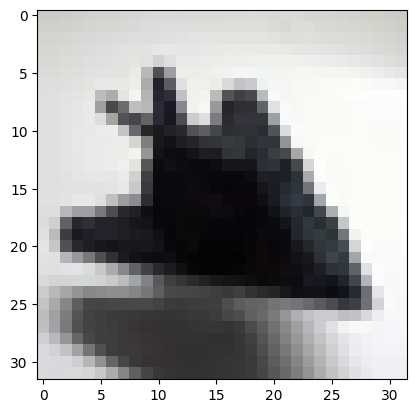

In [20]:
show_example(*dataset[0])

Label: automobile (1)


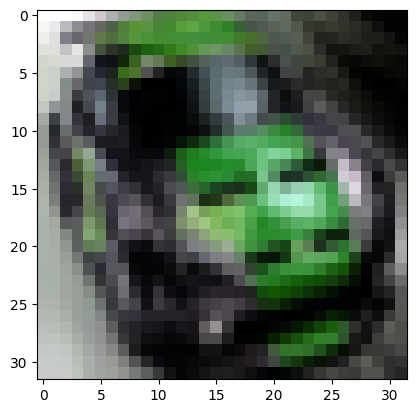

In [22]:
show_example(*dataset[5099])

In [8]:
random_seed=42
torch.manual_seed(random_seed)
train_ds, val_ds = random_split(dataset, [45000, 5000])
len(train_ds), len(val_ds)

(45000, 5000)

In [9]:
from torch.utils.data.dataloader import DataLoader

In [10]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:64], nrow=16).permute(1,2,0))
    break

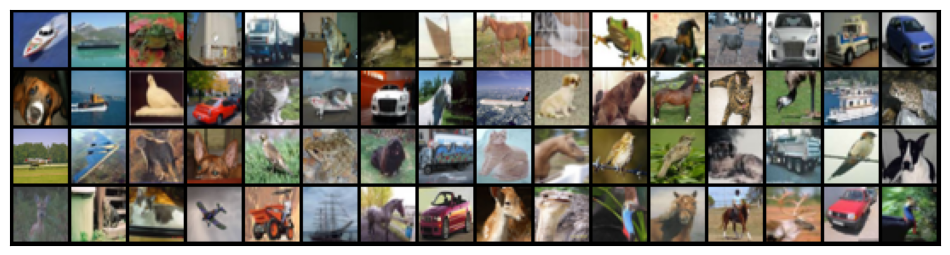

In [30]:
show_batch(train_dl)

In [31]:
def apply_kernel(image, kernel):
  ri, ci = image.shape
  rk, ck = kernel.shape
  ro, co = ri-rk+1, ci-ck+1
  output = torch.zeros((ro,co))
  for i in range(ro):
    for j in range(co):
      output[i,j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
  return output

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [35]:
for images, label in train_dl:
  print("images.shape:", images.shape)
  out = simple_model(images)
  print("out.shape:", out.shape)
  break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


In [13]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out =self(images)
    loss=F.cross_entropy(out, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [14]:
class Cifar10CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, xb):
    return self.network(xb)


In [15]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=4096, out_features=1024, bias=True)
    (15): ReLU()
    (16): Linear(in_features=1024, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512, out_

In [40]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape:', out.shape)
  print('out[0]:', out[0])
  break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0365,  0.0326,  0.0172, -0.0473, -0.0253,  0.0397, -0.0378, -0.0370,
        -0.0288,  0.0111], grad_fn=<SelectBackward0>)


In [16]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)

In [17]:
train_dl = DeviceDataLoader(train_dl, get_default_device())
val_dl = DeviceDataLoader(val_dl, get_default_device())
to_device(model, get_default_device())

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=4096, out_features=1024, bias=True)
    (15): ReLU()
    (16): Linear(in_features=1024, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512, out_

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [19]:
device = get_default_device()
model = to_device(Cifar10CnnModel(), device)

In [20]:
evaluate(model, val_dl)

{'val_loss': 2.302441358566284, 'val_acc': 0.10527344048023224}

In [22]:
opt_func = torch.optim.Adam

In [ ]:
history = fit(10, 0.001, model, train_dl, val_dl, opt_func)